<h1>Airborne Wind Energy Course Workshop 2019</h1>

During this workshop we want you to play around with the Quasi-Steady Model (QSM). The QSM has already been implemented for you, so you don't need to worry about that yourself. We are only going to import some of the implemented functionalities, such that we can quickly start with getting a taste of the performance of a pumping Airborne Wind Energy (AWE) system. Don't let all the code scare you off. We have tried to code all the examples in an intuitive manner. To do so, we have used Python, which in general has a good readability and should not be too hard to understand if you have a basic understanding of programming.

First, let's initiate the objects that specify the wind conditions and the system. We need to input these object later in for calculating the steady state.

In [47]:
# Import required packages.
from qsm import Environment, KiteKinematics, StaticAerodynamics, SteadyState
import matplotlib.pyplot as plt
import numpy as np

# Create an object setting the wind conditions.
env_state = {
    'wind_speed': 7.,  # [m/s]
    'air_density': 1.225,  # [kg/m^3]
}
env_state = Environment(**env_state)

# Create an object setting the system properties.
c_l = 1.
l_to_d = 5.
sys_props = {
    'kite_projected_area': 16.7,  # [m^2]
    'kite_mass': 0.,  # [kg]
    'tether_density': 0.,  # [kg/m^3]
    'tether_diameter': 0.,  # [m]
    'lift_to_drag': l_to_d,  # [-]
    'aerodynamic_force_coefficient': c_l * np.sqrt(1. + (1. / l_to_d) ** 2.),  # [-]
}
sys_props = StaticAerodynamics(**sys_props)
sys_props.tether_mass = 0.  # [m]

From Lloyd's theory we know that the optimal reeling factor is 1/3. In the next code block we are going to check if we can find the same optimal value using the quasi-steady model. To do so, we have to assume the position of the kite. For now let's set the tether length to 1 m, the azimuth and elevation angles to 0, and the course angle to 90 degrees (horizontal flight).

Maximum reel-out power: 13781.5W


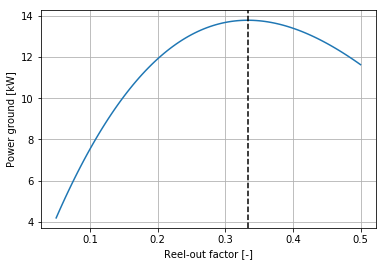

In [48]:
# Create an object containing the kite position and course angle.
kite_position = {
    'straight_tether_length': 1.,  # [m]
    'azimuth_angle': 0.*np.pi/180.,  # [rad]
    'elevation_angle': 0.*np.pi/180.,  # [rad]
    'course_angle': 90.*np.pi/180.,  # [rad]
}
kite_position = KiteKinematics(**kite_position)

# Set the range of reeling factors for which we will determine the steady states.
n_reeling_factors = 100
reel_out_factors = np.linspace(0.05, 0.5, n_reeling_factors)

# Create an array to which we will save our results.
power = np.zeros(n_reeling_factors)

# Iterate over the reel-out factors.
for i, rf in enumerate(reel_out_factors):
    try:
        ss = SteadyState()  # Create object for determining a steady state solution.
        ss.control_settings = ('reeling_factor', rf)  # Set the controlled parameter.
        ss.find_state(sys_props, env_state, kite_position)  # Find the steady state given the input.
        power[i] = ss.power_ground  # Save the result for plotting.
    except:
        power[i] = np.nan
        
print("Maximum reel-out power: {:.1f}W".format(np.nanmax(power)))

# Plot the results.        
plt.plot(reel_out_factors, power*1e-3)
plt.axvline(1/3., linestyle='--', color='k')
plt.xlabel('Reel-out factor [-]')
plt.ylabel('Power ground [kW]')
plt.grid()

So indeed, from the upper plot we can observe that the power is maximum for a reeling factor of 1/3. How does this change when we change the position of the kite? Play around with the position of the kite in the previous code block and see how the curve changes. We have only determined the instaneous performance for a single point during reel-out. However, for pumping AWE systems, we need to reel the kite back in as well. Do you think this will affect the optimal reel-out factor? Lets initiate two kite positions; one that represents the reel-out phase and one that represents the reel-in phase.

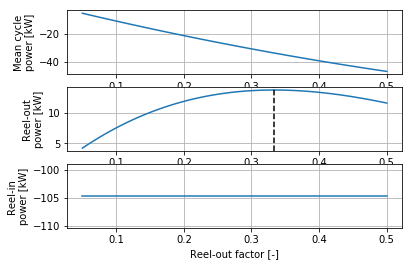

In [49]:
# Create objects containing the kite position and course angle for reel-out and reel-in.
kite_position_out = {
    'straight_tether_length': 1.,  # [m]
    'azimuth_angle': 0.,  # [rad]
    'elevation_angle': 0.*np.pi/180.,  # [rad]
    'course_angle': 90.*np.pi/180.,  # [rad]
}
kite_position_out = KiteKinematics(**kite_position_out)

kite_position_in = {
    'straight_tether_length': 1.,  # [m]
    'azimuth_angle': 0.,  # [rad]
    'elevation_angle': 0.*np.pi/180.,  # [rad]
    'course_angle': 180.*np.pi/180.,  # [rad]
}
kite_position_in = KiteKinematics(**kite_position_in)

# Create a function for calculating the mean cycle power given the reeling factor during reel-out and reel-in.
def calc_mean_cycle_power(rf_out, rf_in):
    # Determine steady state for reel-out.
    ss_out = SteadyState()  
    ss_out.control_settings = ('reeling_factor', rf_out)
    ss_out.find_state(sys_props, env_state, kite_position_out)
    p_out = ss_out.power_ground
    v_out = ss_out.reeling_speed

    # Determine steady state for reel-in.
    ss_in = SteadyState()  
    ss_in.control_settings = ('reeling_factor', rf_in)
    ss_in.find_state(sys_props, env_state, kite_position_in)
    p_in = ss_in.power_ground
    v_in = -ss_in.reeling_speed

    # Assuming that the reeling distance is the same for the reel-out and reel-in: the fraction of time spent per
    # phase can be calculated from the reeling speeds. 
    mean_cycle_power = (p_out/v_out + p_in/v_in) * v_out*v_in/(v_out + v_in)
    
    return mean_cycle_power, p_out, p_in

# Set the range of reeling factors for which we will determine the steady states.
n_reeling_factors = 100
reel_out_factors = np.linspace(0.05, 0.5, n_reeling_factors)
reel_in_factor = -.5

# Create arrays to which we will save our results.
mean_cycle_power = np.zeros(n_reeling_factors)
power_out = np.zeros(n_reeling_factors)
power_in = np.zeros(n_reeling_factors)

# Iterate over the reel-out factors and calculate corresponding mean cycle power.
for i, rf_out in enumerate(reel_out_factors):
    mcp, p_out, p_in = calc_mean_cycle_power(rf_out, reel_in_factor)
    mean_cycle_power[i] = mcp
    power_out[i] = p_out
    power_in[i] = p_in

# Plot the results.
fig, ax = plt.subplots(3, 1)
ax[0].plot(reel_out_factors, mean_cycle_power*1e-3)
ax[0].set_ylabel('Mean cycle\npower [kW]')
ax[1].plot(reel_out_factors, power_out*1e-3)
ax[1].set_ylabel('Reel-out\npower [kW]')
ax[2].plot(reel_out_factors, power_in*1e-3)
ax[2].set_ylabel('Reel-in\npower [kW]')

ax[1].axvline(1/3., linestyle='--', color='k')
ax[-1].set_xlabel('Reel-out factor [-]')
for a in ax:
    a.grid()

It turns out that the mean cycle power is negative and monotonically decreasing. This implies that we are consuming energy regardless of the choice for the reel-out factor. Do you know what could be the cause of this? Generally the kite is depowered during the rectraction phase: the aerodynamics properties of the kite are changed such that less energy needs to be put into the system to lower the kite. Let's try again to identify the optimal reel-out factor, however, this time we differentiate between the aerodynamic properties during reel-out and reel-in.

Maximum mean cycle power: 8412.1W
Corresponding reel-out power: 12987.0W
Corresponding reel-in power: -907.1W


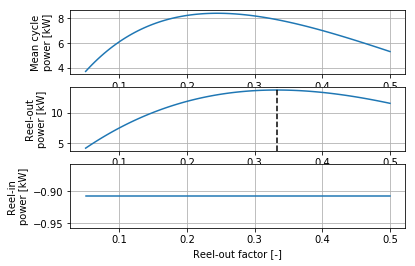

In [50]:
from copy import copy

# Differentiate between system properties for reel-in and reel-out such that we can set the aerodynamic properties
# for the two phases seperately.
sys_props_out = copy(sys_props)
sys_props_in = copy(sys_props)
kite_mass = 20
sys_props_out.kite_mass = kite_mass
sys_props_in.kite_mass = kite_mass

# Lower the lift coefficient for the reel-in phase.
c_l = 0.2
l_to_d = 1.
sys_props_in.lift_to_drag = l_to_d
sys_props_in.aerodynamic_force_coefficient = c_l * np.sqrt(1. + (1. / l_to_d) ** 2.)

# Create a function for calculating the mean cycle power given the reeling factor during reel-out and reel-in.
def calc_mean_cycle_power(rf_out, rf_in):
    # Determine steady state for reel-out.
    ss_out = SteadyState()
    ss_out.control_settings = ('reeling_factor', rf_out)
    ss_out.find_state(sys_props_out, env_state, kite_position_out)  # Input new reel-out system properties object.
    p_out = ss_out.power_ground
    v_out = ss_out.reeling_speed

    # Determine steady state for reel-in.
    ss_in = SteadyState()
    ss_in.control_settings = ('reeling_factor', rf_in)
    ss_in.find_state(sys_props_in, env_state, kite_position_in)  # Input new reel-in system properties object.
    p_in = ss_in.power_ground
    v_in = -ss_in.reeling_speed

    # Calculate mean cycle power from reel-out and reel-in steady state solutions.
    mean_cycle_power = (p_out/v_out + p_in/v_in) * v_out*v_in/(v_out + v_in)
    
    return mean_cycle_power, p_out, p_in

# Set the range of reeling factors for which we will determine the steady states.
n_reeling_factors = 100
reel_out_factors = np.linspace(0.05, 0.5, n_reeling_factors)
reel_in_factor = -.5

# Create arrays to which we will save our results.
mean_cycle_power = np.zeros(n_reeling_factors)
power_out = np.zeros(n_reeling_factors)
power_in = np.zeros(n_reeling_factors)

# Iterate over the reel-out factors and calculate corresponding mean cycle power.
for i, rf_out in enumerate(reel_out_factors):
    mcp, p_out, p_in = calc_mean_cycle_power(rf_out, reel_in_factor)
    mean_cycle_power[i] = mcp
    power_out[i] = p_out
    power_in[i] = p_in
i_max = np.argmax(mean_cycle_power)
print("Maximum mean cycle power: {:.1f}W".format(mean_cycle_power[i_max]))
print("Corresponding reel-out power: {:.1f}W".format(power_out[i_max]))
print("Corresponding reel-in power: {:.1f}W".format(power_in[i_max]))
    
# Plot the results.
fig, ax = plt.subplots(3, 1)
ax[0].plot(reel_out_factors, mean_cycle_power*1e-3)
ax[0].set_ylabel('Mean cycle\npower [kW]')
ax[1].plot(reel_out_factors, power_out*1e-3)
ax[1].set_ylabel('Reel-out\npower [kW]')
ax[2].plot(reel_out_factors, power_in*1e-3)
ax[2].set_ylabel('Reel-in\npower [kW]')

ax[1].axvline(1/3., linestyle='--', color='k')
ax[-1].set_xlabel('Reel-out factor [-]')
for a in ax:
    a.grid()

Nice! We were able to reduce the reel-in power substantially. Now we are actually producing energy over the full range of reel-out factors. The mean cycle power curve shows a maximum at a different reel-out factor than the reel-out power curve. Is it beneficial to reel-out slower or faster compared to the optimal condition that follows from Lloyd's theory? In the previous code block, change the reel-in factor. How does this change the optimal reel-out factor? Note that the optimal reel-out factor is also dependent on the reel-in factor. Lets try to find the combination of reel-out and reel-in factor that maximises the mean cycle power using SciPy's minimize function.

In [32]:
from scipy import optimize as op

# Define the function that is used for evaluating the objective in the optimization.
def objective_function(x):
    # The decision vector x, over which is minimized, consists of the reel-out and reel-in factor.
    rf_out = x[0]
    rf_in = x[1]
    mcp = calc_mean_cycle_power(rf_out, rf_in)[0]  # Call the previously defined function.
    return -mcp  # Maximizing the mean cycle power is equivalent to minimizing its negate.

# Configure optimization problem.
starting_point = (1/3., -1)  # Initial values of the reel-out and reel-in factor, respectively.
bounds = (
    (0., 1.),  # Lower and upper bound for the reel-out factor.
    (-2., -.5),  # Lower and upper bound for the reel-in factor.
)
# Perform optimization.
optimization_result = op.minimize(objective_function, starting_point, bounds=bounds, method='SLSQP')  
print(optimization_result)  # Print optimization results to the screen.

     fun: -9458.307512610905
     jac: array([0.03076172, 0.01318359])
 message: 'Optimization terminated successfully.'
    nfev: 29
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([ 0.26238089, -1.07142904])


Let's verify if the reel-out and reel-in factor combination found by the optimization indeed corresponds to a maximum of the mean cycle power. Is the mean cycle power more sensitive to the reel-out or reel-in factor?

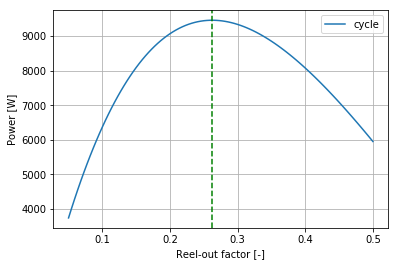

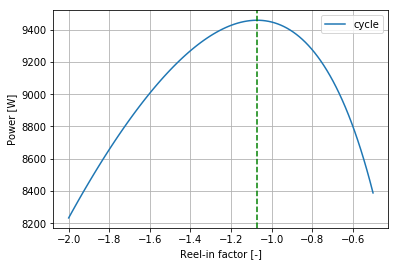

In [42]:
# Get the optimal reel-out and reel-in factor from the optimal point that we found above.
rf_out_opt = optimization_result['x'][0]
rf_in_opt = optimization_result['x'][1]

# Vary the reel-out factor around the optimal point.
n_reeling_factors = 100
reel_out_factors = np.linspace(0.05, 0.5, n_reeling_factors)

# Create array to which we will save our results.
mean_cycle_power = np.zeros(n_reeling_factors)

# Iterate over the reel-out factors and calculate corresponding mean cycle power.
for i, rf_out in enumerate(reel_out_factors):
    mean_cycle_power[i] = calc_mean_cycle_power(rf_out, rf_in_opt)[0]

# Plot the mean cycle power w.r.t. the reel-out factor.
plt.figure()
plt.plot(reel_out_factors, mean_cycle_power, label="cycle")
plt.axvline(rf_out_opt, linestyle='--', color='g')  # Plot a vertical, dashed line at the optimal point.
plt.xlabel('Reel-out factor [-]')
plt.ylabel('Power [W]')
plt.legend()
plt.grid()

# Vary the reel-in factor around the optimal point.
reel_in_factors = np.linspace(-2., -0.5, n_reeling_factors)

# Create array to which we will save our results.
mean_cycle_power = np.zeros(n_reeling_factors)

# Iterate over the reel-in factors and calculate corresponding mean cycle power.
for i, rf_in in enumerate(reel_in_factors):
    mean_cycle_power[i] = calc_mean_cycle_power(rf_out_opt, rf_in)[0]

# Plot the mean cycle power w.r.t. the reel-in factor.
plt.figure()
plt.plot(reel_in_factors, mean_cycle_power, label="cycle")
plt.axvline(rf_in_opt, linestyle='--', color='g')  # Plot a vertical, dashed line at the optimal point.
plt.xlabel('Reel-in factor [-]')
plt.ylabel('Power [W]')
plt.legend()
plt.grid()

So far we have only assessed the system's performance for a single wind speed. However, as you probably know, the performance is highly dependent on the wind speed. The power in the wind is a function of the wind speed cubed. Do you think that the power we can harness using an AWE system is also a function of the wind speed cubed?

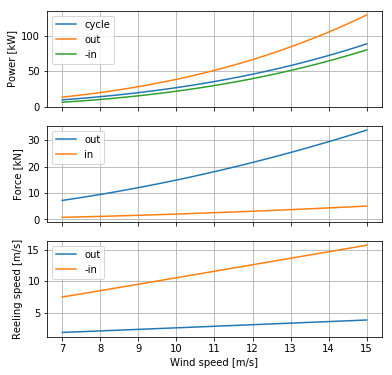

In [43]:
# Define a function for determining cycle performance indicators not only as a function of the reeling factors, but
# also as a function of the wind speed.
def calc_mean_cycle_power_region1(rf_out, rf_in, v_wind):
    # We can re-use the wind conditions object that we created at the start by updating the wind speed.
    env_state.set_reference_wind_speed(v_wind)
    
    # Determine steady state for reel-out.
    ss_out = SteadyState()
    ss_out.control_settings = ('reeling_factor', rf_out)
    ss_out.find_state(sys_props_out, env_state, kite_position_out)
    p_out = ss_out.power_ground 
    v_out = ss_out.reeling_speed

    # Determine steady state for reel-in.
    ss_in = SteadyState()
    ss_in.control_settings = ('reeling_factor', rf_in)
    ss_in.find_state(sys_props_in, env_state, kite_position_in)
    p_in = ss_in.power_ground
    v_in = -ss_in.reeling_speed

    # Calculate mean cycle power from reel-out and reel-in steady state solutions.
    mean_cycle_power = (p_out/v_out + p_in/v_in) * v_out*v_in/(v_out + v_in)
    
    # Return a dictionary object with the results.
    result = {
        'mean_cycle_power': mean_cycle_power,
        'power_reel_out': p_out,
        'tether_force_out': ss_out.tether_force_ground,
        'speed_reel_out': v_out,
        'power_reel_in': p_in,
        'tether_force_in': ss_in.tether_force_ground,
        'speed_reel_in': v_in,
    }
    return result

# Define a new objective function that uses the decision vector and the wind speed as input.
def obj_fun_region1(x, v_wind):
    mcp = calc_mean_cycle_power_region1(x[0], x[1], v_wind)['mean_cycle_power']
    return -mcp

# Configure optimization problem.
starting_point = (1/3., -1)
bounds = ((.1, 1.), (-2., -.5))

# Repeat optimizations for a range of wind speeds.
n_wind_speeds = 30
winds_speeds = np.linspace(7, 15, n_wind_speeds)

# Create arrays to which we will save our results.
mean_cycle_power = np.zeros(n_wind_speeds)
power_out, force_out, speed_out = np.zeros(n_wind_speeds), np.zeros(n_wind_speeds), np.zeros(n_wind_speeds)
power_in, force_in, speed_in = np.zeros(n_wind_speeds), np.zeros(n_wind_speeds), np.zeros(n_wind_speeds)

# Iterate over the range of wind speeds.
for i, v_wind in enumerate(winds_speeds):
    # Perform optimization - wind speed is passed as an argument.
    res = op.minimize(obj_fun_region1, starting_point, bounds=bounds, method='SLSQP', args=(v_wind,))
    
    # Get the result dictionary for the optimal point and write to the result arrays.
    performance_dict = calc_mean_cycle_power_region1(res['x'][0], res['x'][1], v_wind)
    mean_cycle_power[i] = performance_dict['mean_cycle_power']
    power_out[i] = performance_dict['power_reel_out']
    force_out[i] = performance_dict['tether_force_out']
    speed_out[i] = performance_dict['speed_reel_out']
    power_in[i] = performance_dict['power_reel_in']
    force_in[i] = performance_dict['tether_force_in']
    speed_in[i] = performance_dict['speed_reel_in']
    starting_point = res['x']

# Plot specifics on the optimal performance w.r.t. the wind speed.
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(6.0, 6.0))    
ax[0].plot(winds_speeds, mean_cycle_power*1e-3, label="cycle")
ax[0].plot(winds_speeds, power_out*1e-3, label="out")
ax[0].plot(winds_speeds, -power_in*1e-3, label="-in")
ax[0].legend()
ax[1].plot(winds_speeds, force_out*1e-3, label="out")
ax[1].plot(winds_speeds, force_in*1e-3, label="in")
ax[1].legend()
ax[2].plot(winds_speeds, speed_out, label="out")
ax[2].plot(winds_speeds, speed_in, label="-in")
ax[2].legend()

ax[0].set_ylabel('Power [kW]')
ax[1].set_ylabel('Force [kN]')
ax[2].set_ylabel('Reeling speed [m/s]')
ax[2].set_xlabel('Wind speed [m/s]')

for a in ax: a.grid()
    
# z = np.polyfit(winds_speeds[10:20:3], mean_cycle_power[10:20:3], 3)
# p = np.polyval(z, winds_speeds)
# ax[0].plot(winds_speeds, p, '--', label="cubic")

Is the power curve that we obtained realistic? What happens if we evaluate the power for even higher wind speeds? Try it out by changing the maximum value for the 'winds_speeds' array. Probably the curve is not really representative for an actual system: we need to consider some system limits, such as maximum force that the tether can hold and maximum power for which the generator is designed.

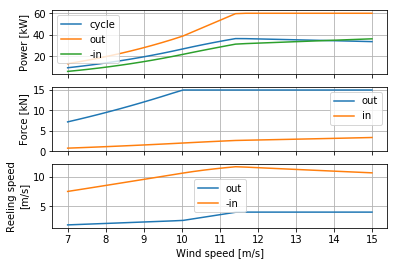

In [46]:
# In the previous code block we have created a function for determining the mean cycle power for the case in which
# no limits are active on the system, which represents the first region of our power curve. Now let's do the same
# for region 2 and region 3; where the maximum tether force and both the maximum tether force and power is reached,
# respectively.

# System limits.
tether_force_limit = 15000  # [N]
power_limit = 60000  # [W]

# Determine cycle performance indicators for the maximum tether force limit case. The reel-out factor is set by the
# tether force limit and is not part of the decision variable anymore.
def calc_mean_cycle_power_region2(rf_in, v_wind):
    # Set wind speed.
    env_state.set_reference_wind_speed(v_wind)
    
    # Determine steady state for reel-out.
    ss_out = SteadyState()
    ss_out.control_settings = ('tether_force_ground', tether_force_limit)  # Use the tether force as a control setting.
    ss_out.find_state(sys_props_out, env_state, kite_position_out)
    p_out = ss_out.power_ground
    v_out = ss_out.reeling_speed

    # Determine steady state for reel-in.
    ss_in = SteadyState()
    ss_in.control_settings = ('reeling_factor', rf_in)
    ss_in.find_state(sys_props_in, env_state, kite_position_in)
    p_in = ss_in.power_ground
    v_in = -ss_in.reeling_speed

    # Calculate mean cycle power from reel-out and reel-in steady state solutions.
    mean_cycle_power = (p_out/v_out + p_in/v_in) * v_out*v_in/(v_out + v_in)
    
    # Return a dictionary object with the results.
    result = {
        'mean_cycle_power': mean_cycle_power,
        'power_reel_out': p_out,
        'tether_force_out': tether_force_limit,
        'speed_reel_out': v_out,
        'power_reel_in': p_in,
        'tether_force_in': ss_in.tether_force_ground,
        'speed_reel_in': v_in,
    }
    return result

# Define the objective function for region 2.
def obj_fun_region2(x, v_wind):
    mcp = calc_mean_cycle_power_region2(x[0], v_wind)['mean_cycle_power']
    return -mcp

# Determine cycle performance indicators for the maximum tether force and power limit case.
def calc_mean_cycle_power_region3(rf_in, v_wind):
    # Set wind speed.
    env_state.set_reference_wind_speed(v_wind)
    
    # The tether force and power limit fully specify the reel-out parameters and are independent of the wind speed.
    p_out = power_limit
    f_out = tether_force_limit
    v_out = p_out/f_out

    # Determine steady state for reel-in.
    ss_in = SteadyState()
    ss_in.control_settings = ('reeling_factor', rf_in)
    ss_in.find_state(sys_props_in, env_state, kite_position_in)
    p_in = ss_in.power_ground
    f_in = ss_in.tether_force_ground
    v_in = -ss_in.reeling_speed

    # Calculate mean cycle power from reel-out and reel-in steady state solutions.
    mean_cycle_power = (p_out/v_out + p_in/v_in) * v_out*v_in/(v_out + v_in)
    
    # Return a dictionary object with the results.
    result = {
        'mean_cycle_power': mean_cycle_power,
        'power_reel_out': p_out,
        'tether_force_out': f_out,
        'speed_reel_out': v_out,
        'power_reel_in': p_in,
        'tether_force_in': ss_in.tether_force_ground,
        'speed_reel_in': v_in,
    }
    return result

# Define the objective function for region 3.
def obj_fun_region3(x, v_wind):
    mcp = calc_mean_cycle_power_region3(x[0], v_wind)['mean_cycle_power']
    return -mcp

# Configure optimization problem.
starting_point = (1/3., -1)

# Repeat optimizations for a range of wind speeds.
n_wind_speeds = 30
winds_speeds = np.linspace(7, 15, n_wind_speeds)

# Create arrays to which we will save our results.
mean_cycle_power = np.zeros(n_wind_speeds)
power_out, force_out, speed_out = np.zeros(n_wind_speeds), np.zeros(n_wind_speeds), np.zeros(n_wind_speeds)
power_in, force_in, speed_in = np.zeros(n_wind_speeds), np.zeros(n_wind_speeds), np.zeros(n_wind_speeds)

i_region = 0  # Counter for tracking to which region the evaluated wind speed belongs.
for i, v_wind in enumerate(winds_speeds):
    # Check which region is active, perform the relevant optimization, and get the result dictionary for the
    # optimal point.
    if i_region == 0:
        bounds = ((.1, 1.), (-2., -.5))
        res = op.minimize(obj_fun_region1, starting_point, bounds=bounds, method='SLSQP', args=(v_wind,))
        performance_dict = calc_mean_cycle_power_region1(res['x'][0], res['x'][1], v_wind)
        # If the tether force limit is exceeded, proceed to the next region.
        if performance_dict['tether_force_out'] > tether_force_limit:
            i_region = 1
            starting_point = (res['x'][1],)
    if i_region == 1:
        bounds = ((-2., -.5),)
        res = op.minimize(obj_fun_region2, starting_point, bounds=bounds, method='SLSQP', args=(v_wind,))
        performance_dict = calc_mean_cycle_power_region2(res['x'][0], v_wind)
        # If the power limit is exceeded, proceed to the next region.
        if performance_dict['power_reel_out'] > power_limit:
            i_region = 2
            starting_point = (res['x'][0],)
    if i_region == 2:
        res = op.minimize(obj_fun_region3, starting_point, bounds=bounds, method='SLSQP', args=(v_wind,))
        performance_dict = calc_mean_cycle_power_region3(res['x'][0], v_wind)
    
    # Update the result arrays.
    mean_cycle_power[i] = performance_dict['mean_cycle_power']
    power_out[i] = performance_dict['power_reel_out']
    force_out[i] = performance_dict['tether_force_out']
    speed_out[i] = performance_dict['speed_reel_out']
    power_in[i] = performance_dict['power_reel_in']
    force_in[i] = performance_dict['tether_force_in']
    speed_in[i] = performance_dict['speed_reel_in']
    starting_point = res['x']

# Plot power curve.
fig, ax = plt.subplots(3, 1, sharex=True)   
ax[0].plot(winds_speeds, mean_cycle_power*1e-3, label="cycle")
ax[0].plot(winds_speeds, power_out*1e-3, label="out")
ax[0].plot(winds_speeds, -power_in*1e-3, label="-in")
ax[0].legend()
ax[1].plot(winds_speeds, force_out*1e-3, label="out")
ax[1].plot(winds_speeds, force_in*1e-3, label="in")
ax[1].legend()
ax[2].plot(winds_speeds, speed_out, label="out")
ax[2].plot(winds_speeds, speed_in, label="-in")
ax[2].legend()

ax[0].set_ylabel('Power [kW]')
ax[1].set_ylabel('Force [kN]')
ax[2].set_ylabel('Reeling speed\n[m/s]')
ax[2].set_xlabel('Wind speed [m/s]')

for a in ax: a.grid()

Thank you for joining the workshop, I hope that you enjoyed it! Feel free to provide me with feedback if you have any. In the lower block you can play around with a piece of code which resolves an idealised flight trajectory of the kite.

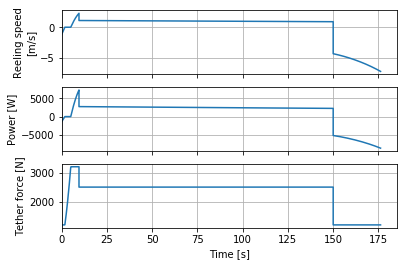

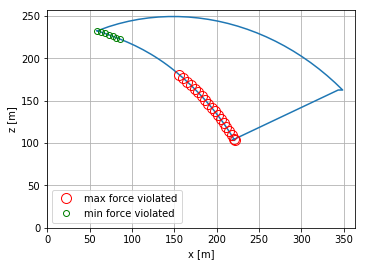

In [45]:
from qsm import Cycle, Environment, SystemProperties, TractionPhase, TractionPhasePattern
import numpy as np

env_state = {
    'wind_speed': 7.,  # [m/s]
    'air_density': 1.225,  # [kg/m^3]
}
env_state = Environment(**env_state)

sys_props = {
    'kite_projected_area': 16.7,  # [m^2]
    'kite_mass': 20.,  # [kg]
    'tether_density': 724.,  # [kg/m^3]
    'tether_diameter': 0.004,  # [m]
    'kite_lift_coefficient_powered': .8,  # [-]
    'kite_drag_coefficient_powered': .2,  # [-]
    'kite_lift_coefficient_depowered': .34,  # [-]
    'kite_drag_coefficient_depowered': .15,  # [-]
    'tether_drag_coefficient': 1.1,  # [-]
    'reeling_speed_min_limit': 0.,  # [m/s]
    'reeling_speed_max_limit': 8.,  # [m/s]
    'tether_force_min_limit': 1200.,  # [N]
    'tether_force_max_limit': 3200.,  # [N]
}
sys_props = SystemProperties(sys_props)

cycle_settings = {
    'cycle': {
        'tether_length_start_retraction': 385,
        'tether_length_end_retraction': 240,
        'elevation_angle_traction': 25.*np.pi/180.,
        'traction_phase': TractionPhase,
    },
    'retraction': {
        'control': ('tether_force_ground', 1200),
    },
    'transition': {
        'control': ('reeling_speed', 0.),
        'time_step': 0.25,
    },
    'traction': {
        'control': ('tether_force_ground', 2500),
        'azimuth_angle': 10.*np.pi/180.,
        'course_angle': 110.*np.pi/180.,
    },
}
cycle = Cycle(cycle_settings)
cycle.run_simulation(sys_props, env_state)
cycle.time_plot(('reeling_speed', 'power_ground', 'tether_force_ground'),
                ('Reeling speed\n[m/s]', 'Power [W]', 'Tether force [N]'))
cycle.trajectory_plot()
# cycle.trajectory_plot3d()